In [1]:
# load training loss
from matplotlib import pyplot as plt
from tifffile import imread
import numpy as np
import pickle
from hydra.experimental import compose, initialize
from omegaconf import OmegaConf
import os

def read_pickle(file_name):
    with open(file_name, 'rb') as f:
        return pickle.load(f)

def tif_to_np(f_name):
    '''
    convert tif to numpy
    '''
    img = imread(f_name)
    img = img.astype('float32')/255
    return img>0.5


# initialize configuration parameters for a specific experiment
experiment = 'ex6'
initialize(config_path=f"../config/{experiment}")
cfg_vqgan = compose(config_name="vqgan")
cfg_transformer = compose(config_name="transformer")
cfg_dataset = compose(config_name="dataset")


/journel/s0/zur74/venv/pnm-old/lib/python3.9/site-packages/hydra/experimental/initialize.py:43: UserWarning: hydra.experimental.initialize() is no longer experimental. Use hydra.initialize()
  deprecation_warning(message=message)
/journel/s0/zur74/venv/pnm-old/lib/python3.9/site-packages/hydra/experimental/initialize.py:45: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  self.delegate = real_initialize(
/journel/s0/zur74/venv/pnm-old/lib/python3.9/site-packages/hydra/experimental/compose.py:25: UserWarning: hydra.experimental.compose() is no longer experimental. Use hydra.compose()
  deprecation_warning(message=message)


In [2]:
root_path = os.path.join(cfg_dataset.checkpoints.PATH, cfg_dataset.experiment)
epoch = 25 # epoch to check training losses
# path_train_loss = os.path.join(root_path,f'training_losses_epoch_{epoch}.pkl')
# path_val_loss = os.path.join(root_path,f'val_loss_ct{0}.pkl')
# train_loss = read_pickle(path_train_loss)
# val_loss = read_pickle(path_val_loss)

In [3]:
train_loss['total_loss_per_epoch']

[0.31136965344194323,
 0.0651264782063663,
 0.06127675612922758,
 0.05435411167796701,
 0.04646931678056717,
 0.041275515380548314]

In [4]:
training_hours = train_loss['time'][-1].seconds /(60*60)
print('Total training time: {:.2f} hours'.format(training_hours))

Total training time: 18.98 hours


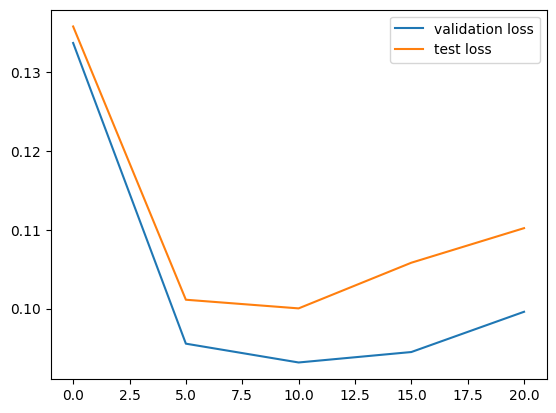

In [5]:
f = plt.figure()
plt.plot(val_loss['epoch'], val_loss['val_loss'], label='validation loss')
plt.plot(val_loss['epoch'], val_loss['test_loss'], label='test loss')
plt.legend()



In [6]:
# f=plt.figure()
# plt.plot( range(len(train_loss['q_loss'])), train_loss['l2_loss'], label='l2_loss')
# plt.xlabel('steps')
# plt.ylabel('loss')
# plt.legend()

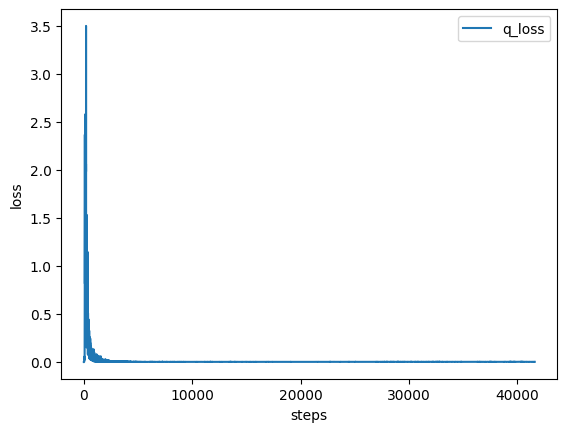

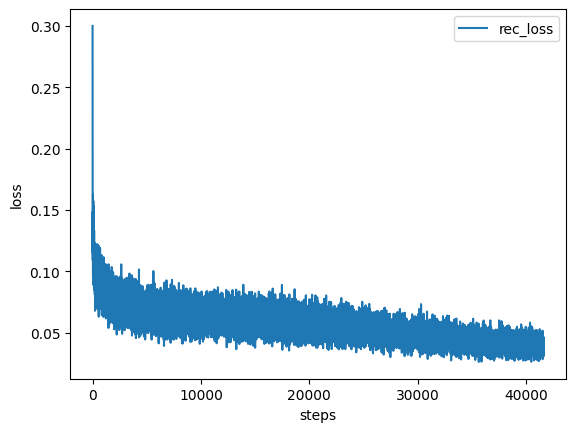

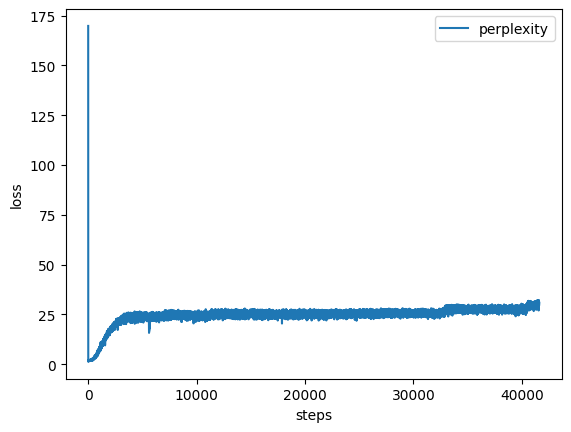

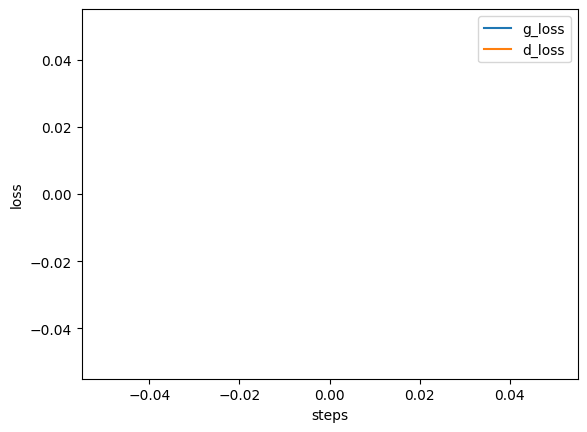

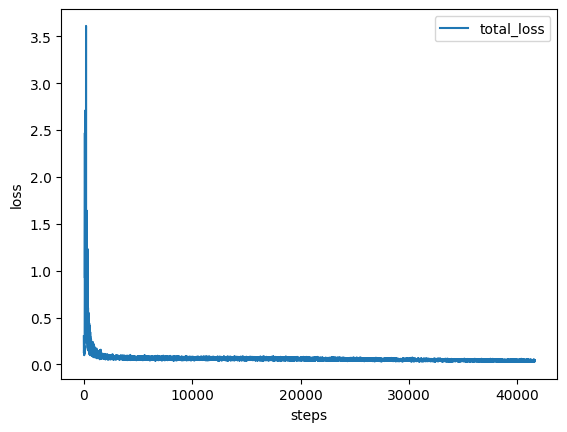

In [7]:
# train_loss.keys()
f=plt.figure()
plt.plot( range(len(train_loss['q_loss'])), train_loss['q_loss'], label='q_loss')
plt.xlabel('steps')
plt.ylabel('loss')
plt.legend()

f=plt.figure()
plt.plot( range(len(train_loss['rec_loss'])), train_loss['rec_loss'], label='rec_loss')
plt.xlabel('steps')
plt.ylabel('loss')
plt.legend()

f=plt.figure()
plt.plot( range(len(train_loss['perplexity'])), train_loss['perplexity'], label='perplexity')
plt.xlabel('steps')
plt.ylabel('loss')
plt.legend()


f=plt.figure()
plt.plot(range(len(train_loss['g_loss'])), train_loss['g_loss'], label='g_loss')
plt.plot(range(len(train_loss['d_loss'])), train_loss['d_loss'], label='d_loss')
plt.xlabel('steps')
plt.ylabel('loss')
plt.legend()

f=plt.figure()
plt.plot(range(len(train_loss['total_loss'])), train_loss['total_loss'], label='total_loss')
plt.xlabel('steps')
plt.ylabel('loss')
plt.legend()

# f=plt.figure()
# alpha = 0.8
# plt.plot(range(steps), train_loss['total_loss'], label='total_loss',alpha=alpha)
# plt.plot(range(steps), train_loss['g_loss'], label='g_loss',alpha=alpha)
# plt.plot(range(steps), train_loss['rec_loss'], label='rec_loss',alpha=alpha)
# plt.plot(range(steps), train_loss['vq_loss'], label='vq_loss',alpha=alpha)
# plt.xlabel('steps')
# plt.ylabel('loss')
# plt.legend()


#### Load the model - check image quanlity

In [33]:
# load pytorch model
import torch
from lpu3dnet.frame import vqgan

# get the global path
PATH = cfg_dataset.PATH.sub_vol

def get_img_list(idx_list,ct_idx):
    # input: ct image idx
    # output: list of images
    img_list = []
    for idx in idx_list:
        img = tif_to_np(f'{PATH}/ct_{ct_idx}/{idx}.tif')
        img_list.append(img)
    return img_list

def img_list_to_np(img_list):
    # input: list of images
    # output: numpy array of images
    image = np.stack(img_list,axis=0)
    return image

def idx_to_matrix(ct_idx,img_idx_list):
    # input: ct image idx, list of image idx
    # output: numpy array of images
    img_list = get_img_list(img_idx_list,ct_idx)
    img_matrix = img_list_to_np(img_list)
    img_matrix = img_matrix[:,np.newaxis,...]
    img_tensor = torch.from_numpy(img_matrix).float()

    return img_tensor,img_matrix

def tensor_to_np(tensor):
    # input: tensor
    # output: numpy array
    return tensor.detach().numpy()

root_path = os.path.join(cfg_dataset.checkpoints.PATH, cfg_dataset.experiment)
epoch = 25

model_vqgan = vqgan.VQGAN(cfg_vqgan)
PATH_model = os.path.join(root_path,f'vqgan_epoch_{epoch}.pth')
model_vqgan.load_state_dict(
    torch.load(
            PATH_model,
            map_location=torch.device('cpu')
               )
    )

model_vqgan.eval()

VQGAN(
  (encoder): Encoder(
    (model): Sequential(
      (0): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): ResidualBlock(
        (block): Sequential(
          (0): GroupNorm(
            (gn): GroupNorm(16, 16, eps=1e-06, affine=True)
          )
          (1): Swish()
          (2): Conv3d(16, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (3): GroupNorm(
            (gn): GroupNorm(16, 64, eps=1e-06, affine=True)
          )
          (4): Swish()
          (5): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        )
        (channel_up): Conv3d(16, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1))
      )
      (2): ResidualBlock(
        (block): Sequential(
          (0): GroupNorm(
            (gn): GroupNorm(16, 64, eps=1e-06, affine=True)
          )
          (1): Swish()
          (2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (3): GroupNo

#### Check reconstruction accuracy

In [34]:
# training idx is [2,3,4,5]
# 0 or 1 can be good for validation
ct_idx = 0

img_idx = [0,100,200,300,400,500]

img_tensor,img_matrix = idx_to_matrix(ct_idx,img_idx)

from cpgan.ooppnm import img_process
img_prc = img_process.Image_process()

with torch.no_grad():
    decode_img,info,_ = model_vqgan(img_tensor)
    decode_img = img_prc.clean_img(decode_img)
# insert a dimension in the channel

decode_img = decode_img[:,np.newaxis,...]

# with torch.no_grad():
#     z = model_vqgan.encode(img_tensor)
#     decode_img = model_vqgan.decode(z)
# decode_img = tensor_to_np(decode_img)

In [35]:
# def compare_images(generated_images, original_images):
#     """
#     Display a comparison of generated images to original images
#     :param generated_images: numpy array of shape (n, 1, 64, 64, 64)
#     :param original_images: numpy array of shape (n, 1, 64, 64, 64)
#     """
    
#     # Ensure the shapes of the two image arrays are the same
#     assert generated_images.shape == original_images.shape, "The generated images and original images should have the same shape."

#     n = generated_images.shape[0]  # number of images
    
#     # Create a figure
#     fig, axes = plt.subplots(n, 2, figsize=(10, 5 * n))
    
#     for i in range(n):
#         # For single row subplot adjustment
#         if n == 1:
#             ax_gen = axes[0]
#             ax_orig = axes[1]
#         else:
#             ax_gen = axes[i, 0]
#             ax_orig = axes[i, 1]

#         # Display generated image
#         ax_gen.imshow(generated_images[i,0,40,:,:], cmap='gray')
#         ax_gen.set_title(f'Generated Image {i+1}')
#         ax_gen.axis('off')

#         # Display original image
#         ax_orig.imshow(original_images[i,0,40,:,:], cmap='gray')
#         ax_orig.set_title(f'Original Image {i+1}')
#         ax_orig.axis('off')
    
#     plt.tight_layout()
#     plt.show()

def compare_images(generated_images, original_images, sections=None):
    """
    Display a comparison of generated images to original images in a 2x4 grid
    :param generated_images: numpy array of shape (6, 1, 64, 64, 64)
    :param original_images: numpy array of shape (6, 1, 64, 64, 64)
    :param sections: list of tuples specifying the sections to visualize, e.g. [(0, 31, ':', ':'), (1, '::', 32, ':')]
    """
    
    # Ensure the shapes of the two image arrays are the same
    assert generated_images.shape == original_images.shape, "The generated images and original images should have the same shape."
    assert generated_images.shape == (6, 1, 64, 64, 64), "Expected shape is (6, 1, 64, 64, 64)"

    # If sections are not provided, use default sections
    if sections is None:
        sections = [(0, 31, ':', ':'), (1, '::', 32, ':'), (2, '::', ':', 32), (3, 20, '::', ':')]

    # Create a figure
    fig, axes = plt.subplots(2, 4, figsize=(20, 12))  # Increased figure height
    
    for i, (ax_gen, ax_orig) in enumerate(zip(axes[0], axes[1])):
        if i < len(sections):
            section = sections[i]
            
            # Always select the first channel (index 0 for the second dimension)
            slice_obj = [section[0], 0]  # First two dimensions: image index and channel

            # Handle the last three dimensions
            for s in section[1:]:
                if s == ':':
                    slice_obj.append(slice(None))
                elif s == '::':
                    slice_obj.append(slice(None, None))
                else:
                    slice_obj.append(s)

            # Ensure we have exactly 5 dimensions in our slice
            while len(slice_obj) < 5:
                slice_obj.append(slice(None))

            # Convert to tuple for indexing
            slice_obj = tuple(slice_obj)

            # Get the 2D slices
            gen_img = generated_images[slice_obj].squeeze()
            orig_img = original_images[slice_obj].squeeze()

            # Ensure the result is 2D
            if gen_img.ndim > 2 or orig_img.ndim > 2:
                raise ValueError(f"Slicing resulted in non-2D array for section {section}. Please adjust your section definition.")

            # Display generated image
            ax_gen.imshow(gen_img, cmap='gray')
            ax_gen.axis('off')

            # Display original image
            ax_orig.imshow(orig_img, cmap='gray')
            ax_orig.axis('off')
    
    # Add row labels
    fig.text(0.5, 0.95, 'Generated Images', ha='center', va='center', fontsize=16)
    fig.text(0.5, 0.5, 'Original Images', ha='center', va='center', fontsize=16)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.93, bottom=0.07, hspace=0.1)  # Adjust the top, bottom margins, and space between rows
    plt.show()

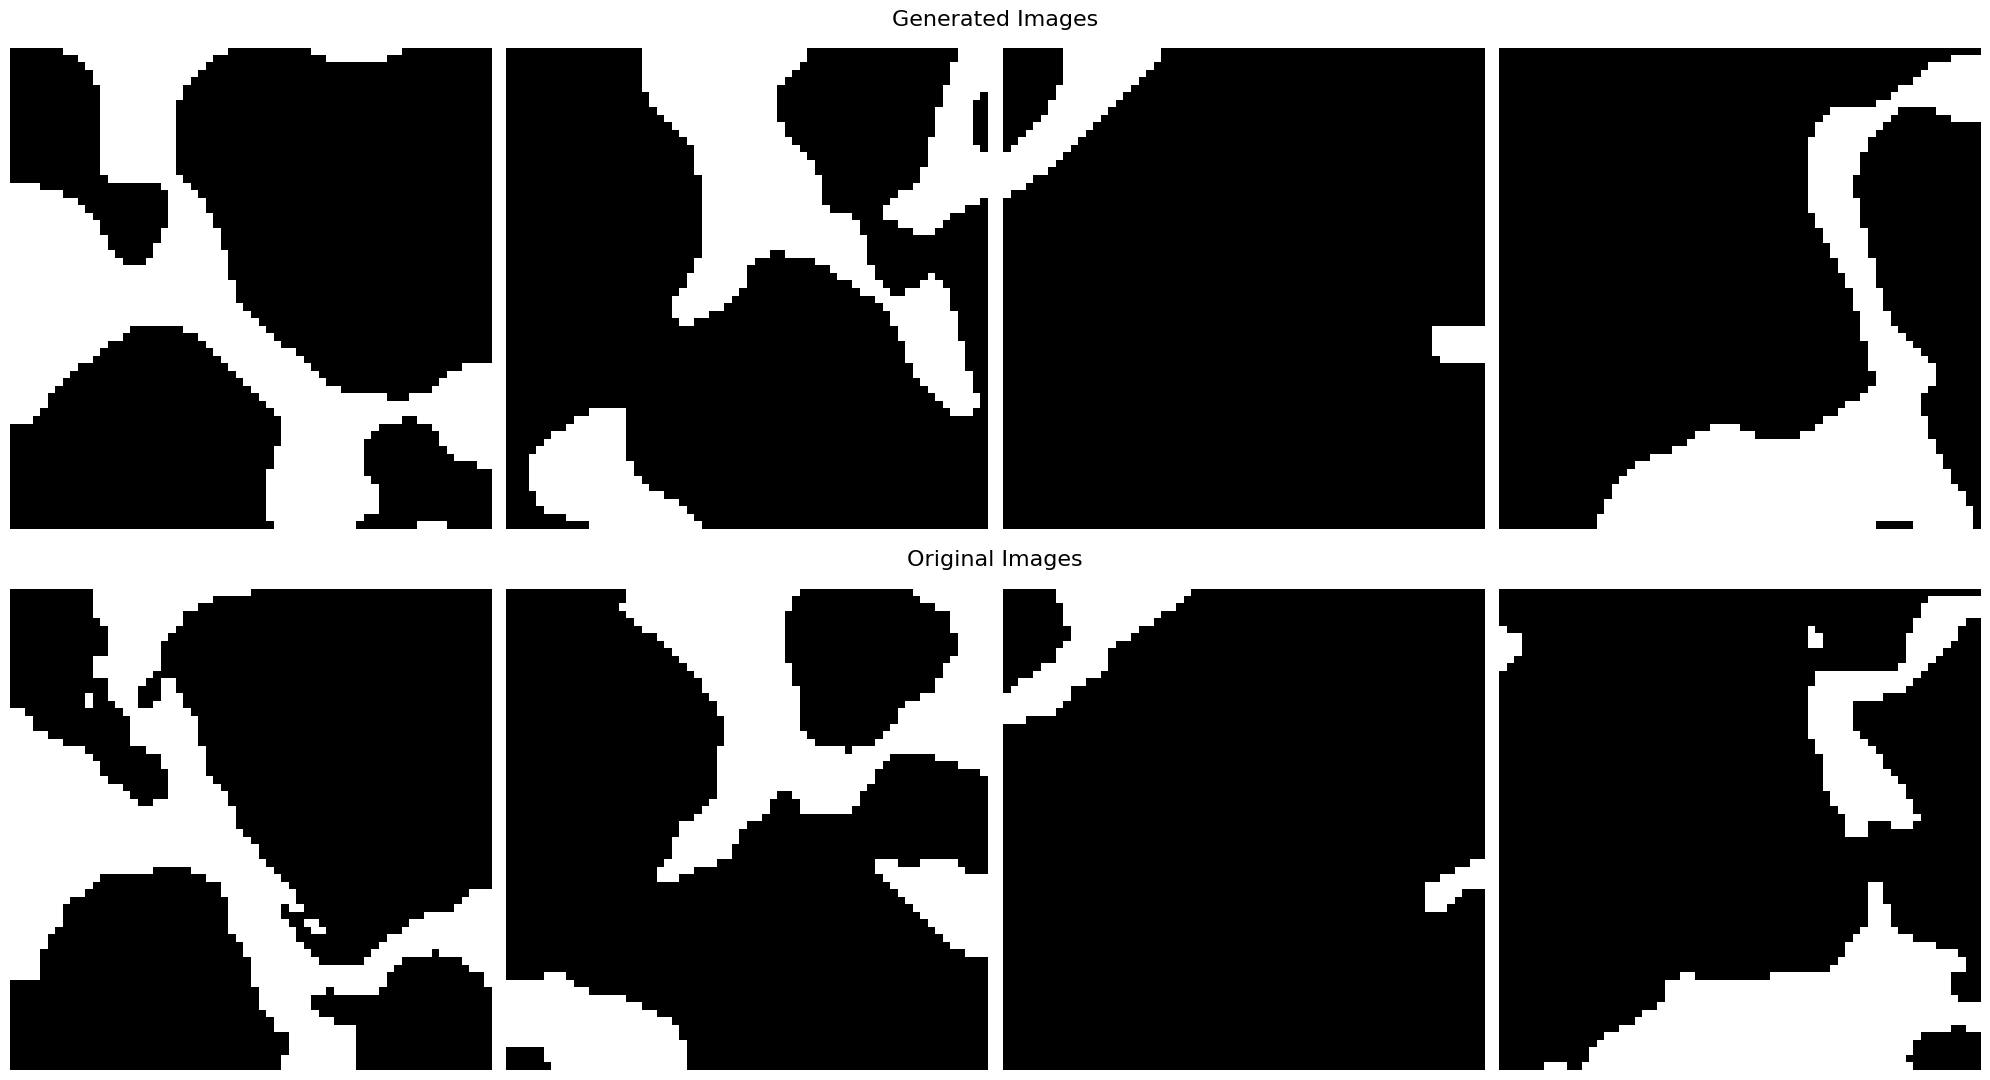

In [36]:
compare_images(decode_img,img_matrix)

#### Check reconstruction accuracy

VQVAE sampled $64^3$ image tokens decoded performance

In [11]:
# read pickle file

def read_pickle(file_name):
    with open(file_name, 'rb') as f:
        return pickle.load(f)
    

real_phys = read_pickle(f'db/real_phys.pkl')
generate_phys = read_pickle(f'db/generate_phys_10.pkl')



In [12]:
# porosity reconstruction
phi_real = []
phi_gen = []
k_real = []
k_gen = []
eul_real = []
eul_gen = []

for ds_real, ds_gen in zip(real_phys,generate_phys):
    if ds_real and ds_gen:
        phi_real.append(ds_real['porosity'])
        phi_gen.append(ds_gen['porosity'])
        k_real.append(ds_real['kabs'][0])
        k_gen.append(ds_gen['kabs'][0])
        eul_real.append(ds_real['euler'])
        eul_gen.append(ds_gen['euler'])




In [17]:
# calculate mean absolute error between real and generated porosity
phi_real = np.array(phi_real)
phi_gen = np.array(phi_gen)
k_real = np.array(k_real)
k_gen = np.array(k_gen)

mae_phi =   np.mean(np.abs(phi_real - phi_gen))
mae_k =  np.mean(np.abs(k_real - k_gen))

mask = (k_real > 0) & (k_real <= 2000) & (k_gen > 0) & (k_gen <= 1600)

k_real_filtered = k_real[mask]
k_gen_filtered = k_gen[mask]

# Calculate mean absolute error after filtering
mae_k_filtered = np.mean(np.abs(k_real_filtered - k_gen_filtered))
print(f'MAE k after filtering: {mae_k_filtered:.4f}')


print(f'MAE porosity: {mae_phi:.4f}')
print(f'MSE k: {mae_k:.4f}')

MAE k after filtering: 93.8797
MAE porosity: 0.0048
MSE k: 98.0609


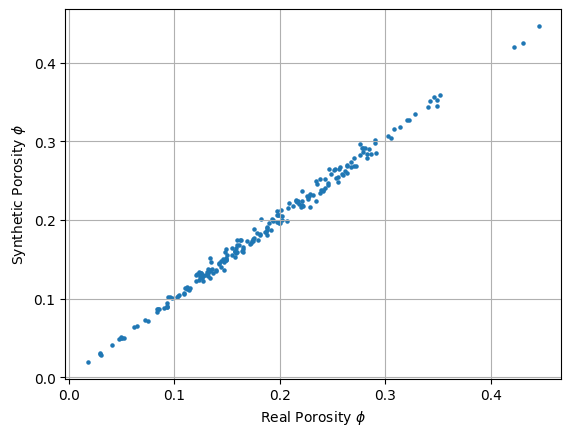

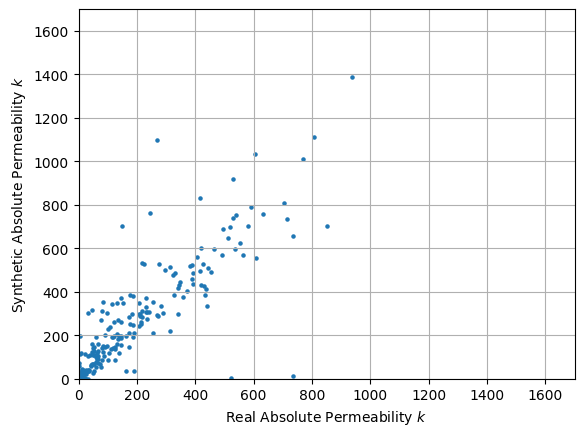

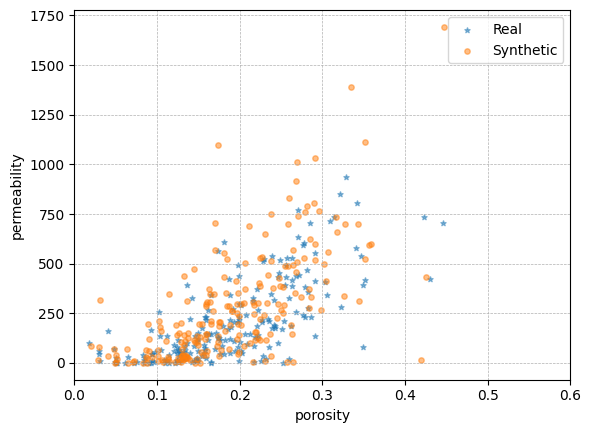

In [18]:
f = plt.figure()
plt.scatter(phi_real,phi_gen,s=5)
plt.xlabel('Real Porosity $\phi$')
plt.ylabel('Synthetic Porosity $\phi$')
plt.grid(True)

f = plt.figure()
plt.scatter(k_real_filtered,k_gen_filtered,s=5)
plt.xlim([0,1700])
plt.ylim([0,1700])
plt.xlabel('Real Absolute Permeability $k$')
plt.ylabel('Synthetic Absolute Permeability $k$')
plt.grid(True)


# phi vs kabs
f = plt.figure()
plt.scatter(phi_real,k_real,marker='*',s=15,alpha=0.5,label='Real')
plt.scatter(phi_gen,k_gen,marker='o',s=15,alpha=0.5,label='Synthetic')
plt.xlabel('porosity')
plt.ylabel('permeability')
plt.xlim([0,0.6])
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
# f = plt.figure()
# plt.scatter(eul_real,eul_gen,s=5)
# plt.xlim([-50,50])
# plt.ylim([-50,50])
# plt.xlabel('real euler')
# plt.ylabel('generated euler')


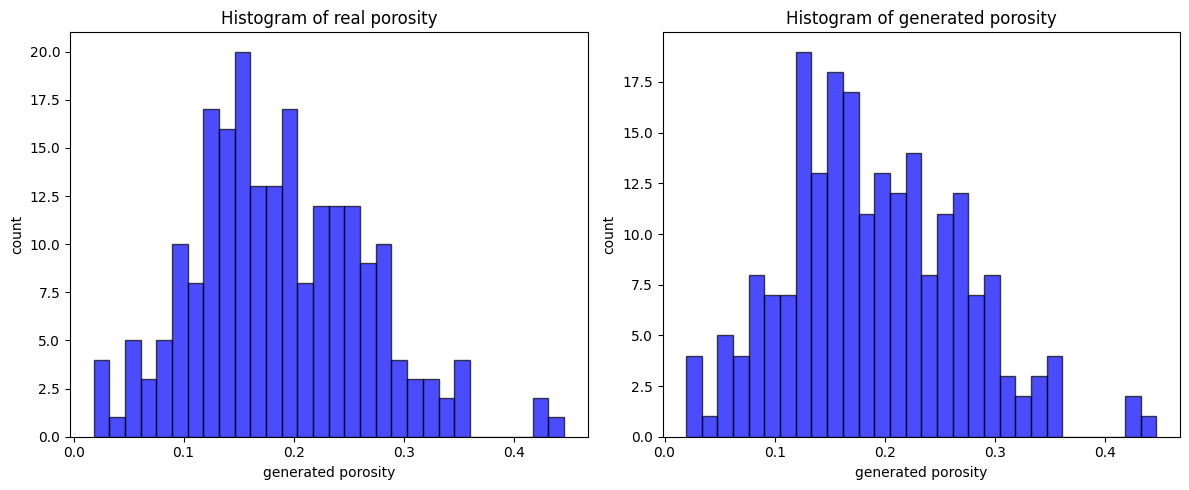

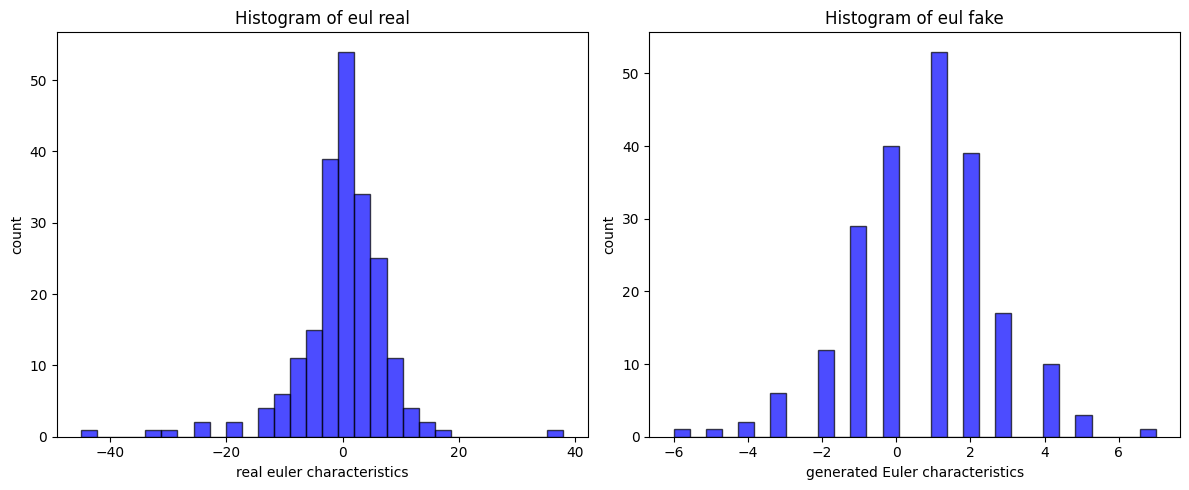

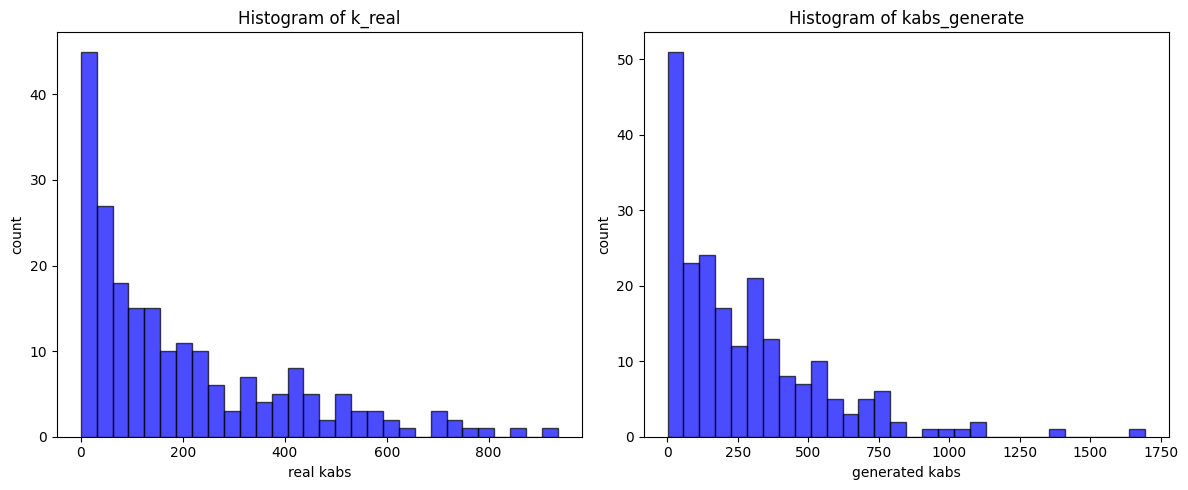

In [6]:
# plot the histogram of real phys

f, ax = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Plot the first histogram
ax[0].hist(phi_real, bins=30, edgecolor='black', facecolor='blue', alpha=0.7)
ax[0].set_xlabel('generated porosity')
ax[0].set_ylabel('count')
ax[0].set_title('Histogram of real porosity')

# Plot the second histogram
ax[1].hist(phi_gen, bins=30, edgecolor='black', facecolor='blue', alpha=0.7)
ax[1].set_xlabel('generated porosity')
ax[1].set_ylabel('count')
ax[1].set_title('Histogram of generated porosity')

# Display the figure with the histograms
plt.tight_layout()  # Adjusts subplot params so that subplots are nicely fit in the figure
plt.show()



f, ax = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Plot the first histogram
ax[0].hist(eul_real, bins=30, edgecolor='black', facecolor='blue', alpha=0.7)
ax[0].set_xlabel('real euler characteristics')
ax[0].set_ylabel('count')
ax[0].set_title('Histogram of eul real')

# Plot the second histogram
ax[1].hist(eul_gen, bins=30, edgecolor='black', facecolor='blue', alpha=0.7)
ax[1].set_xlabel('generated Euler characteristics')
ax[1].set_ylabel('count')
ax[1].set_title('Histogram of eul fake')

# Display the figure with the histograms
plt.tight_layout()  # Adjusts subplot params so that subplots are nicely fit in the figure
plt.show()




f, ax = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Plot the first histogram
ax[0].hist(k_real, bins=30, edgecolor='black', facecolor='blue', alpha=0.7)
ax[0].set_xlabel('real kabs')
ax[0].set_ylabel('count')
ax[0].set_title('Histogram of k_real')

# Plot the second histogram
ax[1].hist(k_gen, bins=30, edgecolor='black', facecolor='blue', alpha=0.7)
ax[1].set_xlabel('generated kabs')
ax[1].set_ylabel('count')
ax[1].set_title('Histogram of kabs_generate')

# Display the figure with the histograms
plt.tight_layout()  # Adjusts subplot params so that subplots are nicely fit in the figure
plt.show()

